# Assignment 3: Restricted Boltzmann Machines

## Submitted By: Aarathi Vijayachandran (244267)

### Assignment question is available here: https://ovgu-ailab.github.io/lgm2024/assignment3.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# Loading MNIST dataset and preprocessing
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = tf.where(x_train >= 128, 1, 0)
x_test = tf.where(x_test >= 128, 1, 0)
x_train = tf.reshape(x_train, [-1, 784])
x_test = tf.reshape(x_test, [-1, 784])
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
m = 256
train_dataset = train_dataset.batch(m).repeat()

11490434/11490434 [==============================] - 0s 0us/step


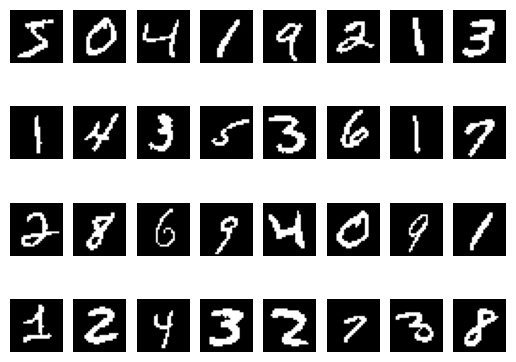

In [2]:
# Take one batch of the dataset
for images in train_dataset.take(1):
    # Reshape the images back to their original shape
    images = tf.reshape(images, [-1, 28, 28])

    # Plot the images
    fig, axes = plt.subplots(4, 8)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
    plt.show()

In [3]:

# Define model parameters
n_hidden = 128
k_gibbs_steps = 50
learning_rate = 0.001
train_iters = 200
b = tf.Variable(np.random.uniform(-.5, .5, size=(784, 1)))
c = tf.Variable(np.random.uniform(-.5, .5, size=(n_hidden, 1)))
W = tf.Variable(np.random.uniform(-.5, .5, size=(784, n_hidden)))

In [4]:
# Define sampling functions and energy functions
def sample_hidden_given_visible(visible):
    VW = tf.matmul(visible, W)
    c_broadcasted = tf.broadcast_to(tf.transpose(c), tf.shape(VW))
    return tf.nn.sigmoid(VW + c_broadcasted)

def sample_visible_given_hidden(hidden):
    HW = tf.matmul(hidden, tf.transpose(W))
    b_broadcasted = tf.broadcast_to(tf.transpose(b), tf.shape(HW))
    return tf.nn.sigmoid(HW + b_broadcasted)

def energy_function_batch(visible, hidden):
    return -tf.matmul(visible, b) - tf.matmul(hidden, c) - tf.reduce_sum(tf.matmul(visible, W) * hidden, axis=1)

In [5]:

# Positive phase training function
def positive_training(data):
    with tf.GradientTape() as tape:
        tape.watch([W, b, c])
        visible = tf.constant(tf.cast(data, tf.float64), dtype=tf.float64)
        hidden_probs = sample_hidden_given_visible(visible)
        hidden = tf.constant(tf.cast(tfd.Bernoulli(probs=hidden_probs).sample(), tf.float64), dtype=tf.float64)
        energy = -energy_function_batch(visible, hidden)
    grads = tape.gradient(energy, [W, b, c])
    return visible, hidden, grads

In [6]:

# Negative phase training functions
def negative_training_basic():
    V_mc = tf.random.uniform((m, 784), dtype=tf.float64)
    V_mc = V_mc / tf.reduce_sum(V_mc, axis=0)
    with tf.GradientTape() as tape:
        H = []
        tape.watch([W, b, c])
        for i in range(k_gibbs_steps):
            H_probs = sample_hidden_given_visible(V_mc)
            H = tf.cast(tfd.Bernoulli(probs=H_probs).sample(), tf.float64)
            V_mc_probs = sample_visible_given_hidden(H)
            V_mc = tf.cast(tfd.Bernoulli(probs=V_mc_probs).sample(), tf.float64)
            energy = -energy_function_batch(V_mc, H)
    grads = tape.gradient(energy, [W, b, c])
    return V_mc, H, grads


In [7]:

def negative_training_cd(data):
    V_mc = tf.constant(tf.cast(data, tf.float64), dtype=tf.float64)
    with tf.GradientTape() as tape:
        H = []
        tape.watch([W, b, c])
        for i in range(k_gibbs_steps):
            H_probs = sample_hidden_given_visible(V_mc)
            H = tf.cast(tfd.Bernoulli(probs=H_probs).sample(), tf.float64)
            V_mc_probs = sample_visible_given_hidden(H)
            V_mc = tf.cast(tfd.Bernoulli(probs=V_mc_probs).sample(), tf.float64)
            energy = -energy_function_batch(V_mc, H)
    grads = tape.gradient(energy, [W, b, c])
    return V_mc, H, grads


In [8]:

def negative_training_pcd(V_prev):
    if V_prev is None:
        V_prev = tf.random.uniform((m, 784), dtype=tf.float64)
        V_prev = V_prev / tf.reduce_sum(V_prev, axis=0)
    with tf.GradientTape() as tape:
        H = []
        tape.watch([W, b, c])
        for i in range(k_gibbs_steps):
            H_probs = sample_hidden_given_visible(V_prev)
            H = tf.cast(tfd.Bernoulli(probs=H_probs).sample(), tf.float64)
            V_prev_probs = sample_visible_given_hidden(H)
            V_prev = tf.cast(tfd.Bernoulli(probs=V_prev_probs).sample(), tf.float64)
            energy = -energy_function_batch(V_prev, H)
    grads = tape.gradient(energy, [W, b, c])
    return V_prev, H, grads


In [12]:

# Training loop
V_n = None
for i, data in enumerate(train_dataset):
    V_p, H_p, grads_p = positive_training(data)
    V_n, H_n, grads_n = negative_training_cd(data)


    W_grad = (grads_p[0] - grads_n[0]) / m
    b_grad = (grads_p[1] - grads_n[1]) / m
    c_grad = (grads_p[2] - grads_n[2]) / m


    W.assign_add(learning_rate * W_grad)
    b.assign_add(learning_rate * b_grad)
    c.assign_add(learning_rate * c_grad)
    #print(i)
    if i == train_iters:
        break


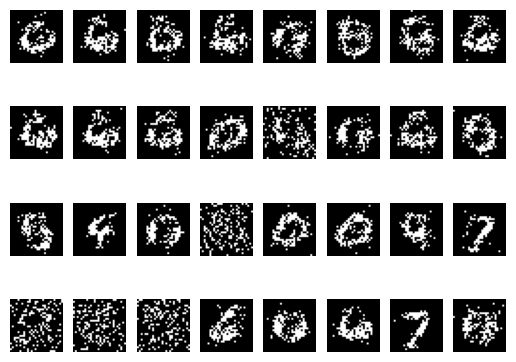

In [13]:

# Generate and visualize samples
V_mc = tf.random.uniform((32, 784), dtype=tf.float64)
V_mc = V_mc / tf.reduce_sum(V_mc, axis=0)
H = []
for i in range(k_gibbs_steps):
    H_probs = sample_hidden_given_visible(V_mc)
    H = tf.cast(tfd.Bernoulli(probs=H_probs).sample(), tf.float64)
    V_mc_probs = sample_visible_given_hidden(H)
    V_mc = tf.cast(tfd.Bernoulli(probs=V_mc_probs).sample(), tf.float64)

x_reshaped = tf.reshape(V_mc, (32, 28, 28))
fig, axes = plt.subplots(4, 8)
for i in range(4):
    for j in range(8):
        index = i * 8 + j
        axes[i, j].imshow(x_reshaped[index], cmap='gray')
        axes[i, j].axis('off')

plt.show()
